In [61]:
'''!pip3 install scanpy
!conda install -y -c anaconda cmake
!pip3 install leidenalg
!pip install louvain
!conda install -c conda-forge leidenalg'''

SyntaxError: invalid syntax (2557351803.py, line 1)

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import leidenalg
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_10x_h5('/Users/pankti/Desktop/Bioinformatics/github/research-singlecellaRNAsequencing/data/SC3_v3_NextGem_DI_CellPlex_CSP_DTC_Sorted_30K_Multiplex_count_raw_feature_bc_matrix.h5')
# the directory with the `.mtx` file use gene symbols for the variable names (variables-axis index) 
# write a cache file for faster subsequent reading

/Users/pankti/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pankti/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata.var_names_make_unique()

In [45]:
adata

AnnData object with n_obs × n_vars = 60797 × 5580
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells

In [6]:
#IF YOU ARE DOING MOUSE YOU MIGHT NEED TO CHANGE MT- to Mt. Always double check you actually labeld MT
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [7]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

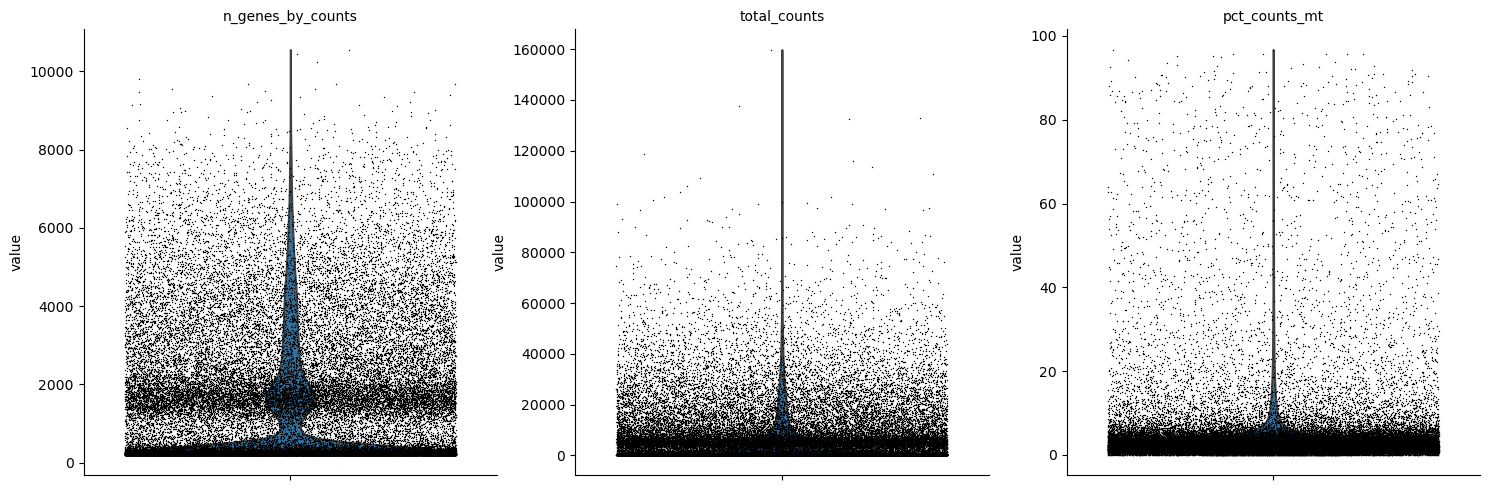

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

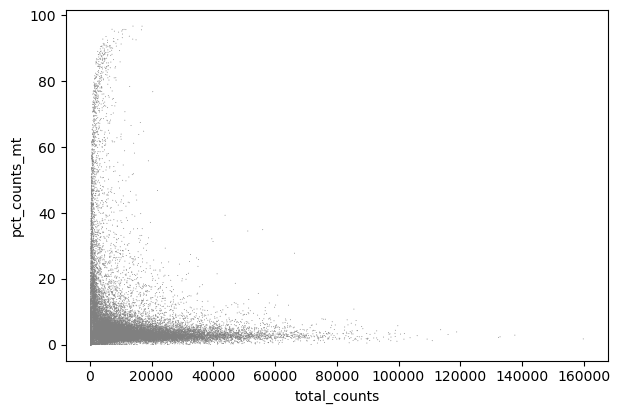

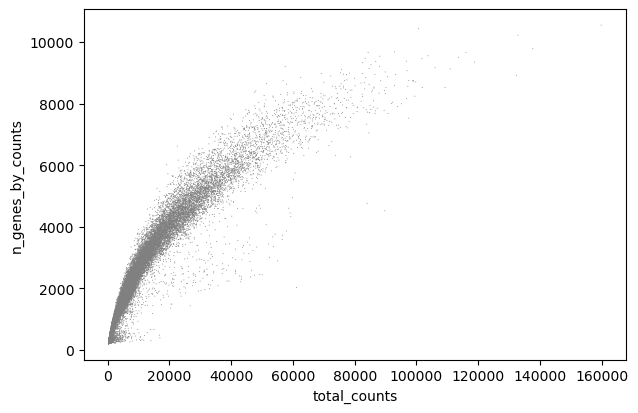

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

201.0 to 6031.0999999999985


In [11]:
adata[adata.obs.index == 'AAACCCAAGCCTGTGC-1']

View of AnnData object with n_obs × n_vars = 0 × 28491
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
#adata = adata[adata.obs.n_genes_by_counts < 7000, :] #example if you wanted to pick a number yourself
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
adata = adata[adata.obs.pct_counts_mt < 20]

In [13]:
adata.X[1, :].sum()

3651.0

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4) # normalize every cell to 10000 UMI

/Users/pankti/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
adata.X[0, :].sum()

10000.011

In [16]:
sc.pp.log1p(adata) #change to log counts

# Clustering

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values

/Users/pankti/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [18]:
adata.raw = adata #save raw data before processing values and further filtering

In [19]:
adata = adata[:, adata.var.highly_variable] #filter highly variable

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed

In [21]:
sc.pp.scale(adata, max_value=10) #scale each gene to unit variance

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

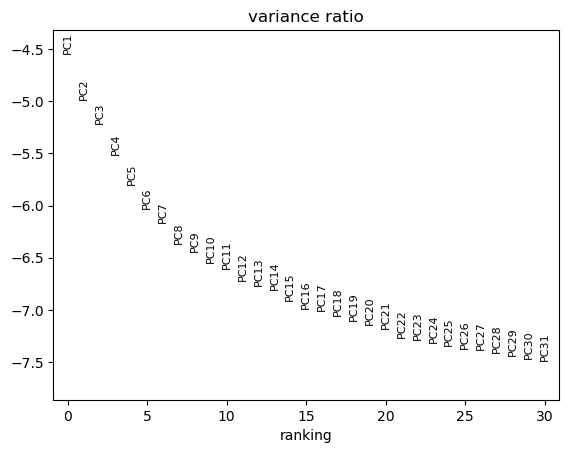

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

In [25]:
sc.tl.umap(adata)

/Users/pankti/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pankti/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


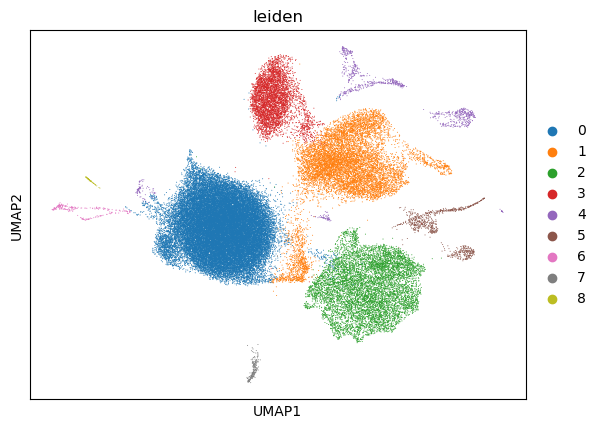

In [26]:
sc.tl.leiden(adata, resolution = 0.10)
sc.pl.umap(adata, color=['leiden'])

In [27]:
sc.tl.umap(adata, n_components = 3)

In [28]:
color = dict(zip(range(0,15), plt.cm.tab20(range(0,15))))

In [29]:
umap = adata.obsm['X_umap']
umap

array([[10.877444 , 11.388606 ,  8.369578 ],
       [ 9.5988455, 13.2148905, 13.538002 ],
       [ 6.3371086, 11.270638 , 16.349077 ],
       ...,
       [ 8.302081 ,  9.4320135, 10.770857 ],
       [11.171174 , 11.535765 ,  7.185417 ],
       [ 9.225476 , 11.763746 ,  9.780496 ]], dtype=float32)

In [73]:
# 360 degree rotated animation
# for i in range(0, 360):
#     fig = plt.figure(figsize = (12, 12))
#     ax = fig.add_subplot(projection = '3d')

#     ax.scatter(umap[:,0], umap[:, 1], umap[:, 2], c = adata.obs.leiden.astype('int').map(color))

#     x_center = (umap[:, 0].max() + umap[:, 0].min())/2
#     y_center = (umap[:, 1].max() + umap[:, 1].min())/2
#     z_center = (umap[:, 2].max() + umap[:, 2].min())/2

#     ax.plot([x_center, x_center], [y_center, y_center], [umap[:, 2]. min() - 2, umap[:, 2]. max() + 2], c = 'k', lw = 3)
#     ax.plot([x_center, x_center], [umap[:, 1]. min() - 2, umap[:, 1]. max() + 2], [z_center, z_center], c = 'k', lw = 3)
#     ax.plot([umap[:, 0]. min() - 2, umap[:, 0]. max() + 2], [y_center, y_center], [z_center, z_center], c = 'k', lw = 3)

#     ax.view_init(20, i)
#     ax.axis('off')

#     plt.savefig(f'/Users/pankti/Desktop/Bioinformatics/github/research-singlecellaRNAsequencing/output/umap_figs/{i:03d}.png', dpi = 100, facecolor = 'white')
#     plt.close(fig)
#     # plt.show()

In [72]:
#!convert -delay 5 /Users/pankti/Desktop/Bioinformatics/github/research-singlecellaRNAsequencing/output/*.png /Users/pankti/Desktop/Bioinformatics/github/research-singlecellaRNAsequencing/output/umap.gif


/Users/pankti/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


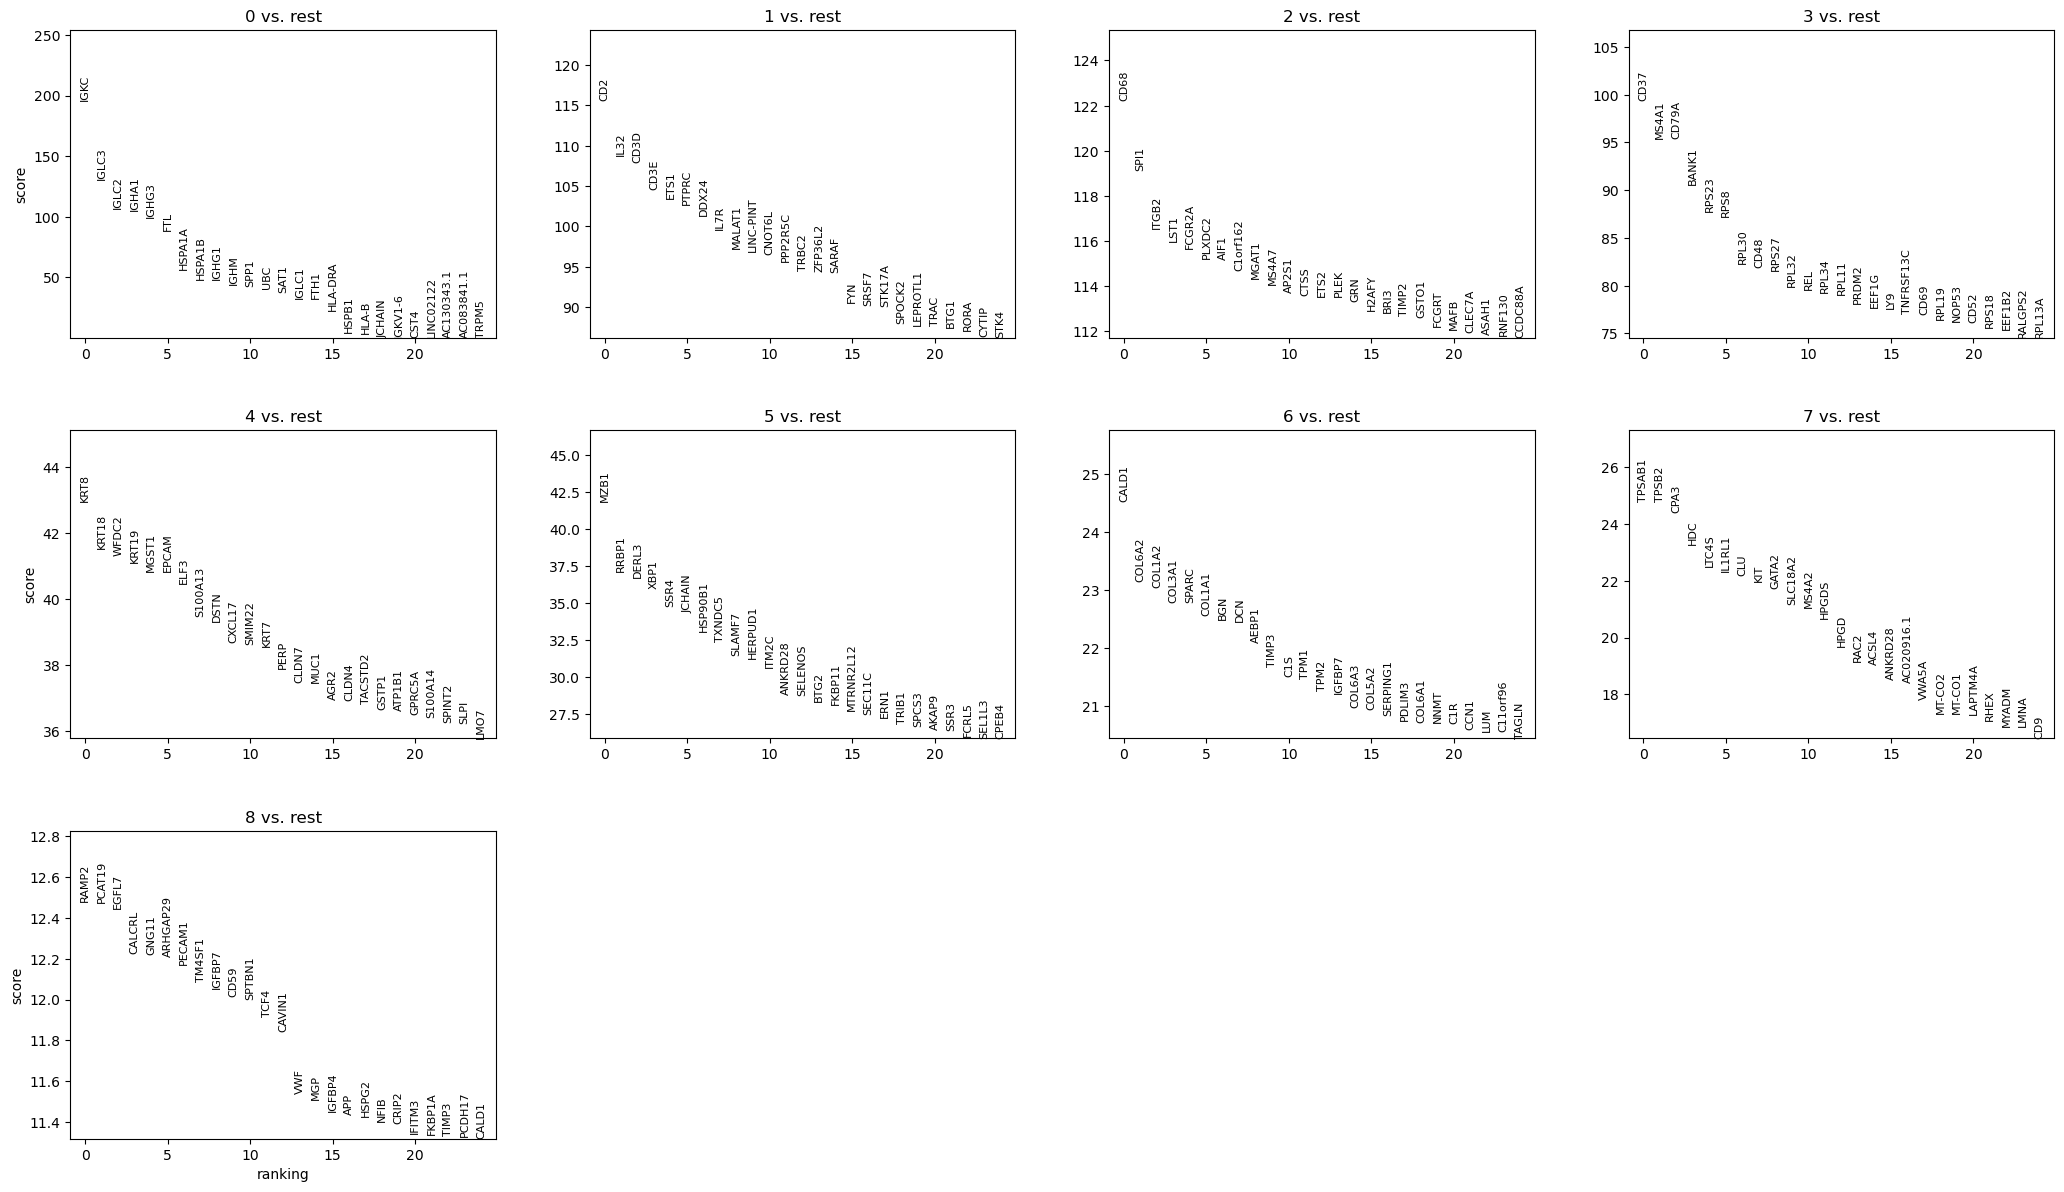

In [30]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
results = adata.uns['rank_genes_groups']

In [33]:
results['names']

rec.array([('IGKC', 'CD2', 'CD68', 'CD37', 'KRT8', 'MZB1', 'CALD1', 'TPSAB1', 'RAMP2'),
           ('IGLC3', 'IL32', 'SPI1', 'MS4A1', 'KRT18', 'RRBP1', 'COL6A2', 'TPSB2', 'PCAT19'),
           ('IGLC2', 'CD3D', 'ITGB2', 'CD79A', 'WFDC2', 'DERL3', 'COL1A2', 'CPA3', 'EGFL7'),
           ...,
           ('PRRC2C', 'HLA-DRA', 'IGLC2', 'HSPA1A', 'IGLC3', 'B2M', 'IGLC3', 'IGLC3', 'FTH1'),
           ('MT-ND3', 'IGKC', 'IGLC3', 'FTH1', 'B2M', 'FTL', 'HLA-DRA', 'HLA-DRA', 'IGKC'),
           ('MTRNR2L12', 'FTL', 'IGKC', 'FTL', 'IGKC', 'FTH1', 'IGKC', 'IGKC', 'FTL')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O'), ('8', 'O')])

In [34]:
results['names'].dtype.names
# type(results)

('0', '1', '2', '3', '4', '5', '6', '7', '8')

In [35]:
out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))

In [36]:
out.shape

(256420, 5)

Find Markers

In [37]:
markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

In [38]:
markers = markers[(markers.pval_adj < 0.05) & (abs(markers.lfc) > 1)]

In [40]:
adata.raw.var_names

Index(['AL627309.1', 'AL627309.3', 'AL627309.5', 'AL627309.4', 'AP006222.2',
       'AL669831.2', 'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115',
       ...
       'AC004556.3', 'AC233755.2', 'AC233755.1', 'AC136352.3', 'AC136616.1',
       'AC136616.2', 'AC141272.1', 'AC023491.2', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=28491)

In [49]:
markers
markers.to_csv("scRNA_markers.csv", sep=',', index=False, encoding='utf-8')

In [46]:
markers[markers.cluster == '4']

,Gene,scores,pval_adj,lfc,cluster
113964,KRT8,42.949875,0.0,4.467412,4
113965,KRT18,41.534752,0.0,4.275253,4
113966,WFDC2,41.301937,0.0,4.621908,4
113967,KRT19,41.082798,0.0,4.245772,4
113968,MGST1,40.83503,0.0,4.498344,4
...,...,...,...,...,...
142450,HLA-DRA,-23.318857,0.0,-1.639681,4
142451,HSPA1A,-23.613056,0.0,-1.026129,4
142452,IGLC3,-24.799284,0.0,-2.775813,4
142453,B2M,-35.925182,0.0,-1.321237,4


In [41]:
adata.raw.X.toarray().shape  #[:,zik_i]

(60797, 28491)

In [42]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGAGTGAAG-1,208,208,252.0,1.0,0.396825,0
AAACCCAAGATAGGGA-1,1282,1282,3651.0,137.0,3.752397,1
AAACCCAAGATCACCT-1,1594,1594,4755.0,185.0,3.890641,3
AAACCCAAGATCCCGC-1,231,231,285.0,10.0,3.508772,0
AAACCCAAGATCGACG-1,393,393,609.0,30.0,4.926108,0
...,...,...,...,...,...,...
TTTGTTGTCTACCTTA-1,230,230,296.0,6.0,2.027027,0
TTTGTTGTCTCAACGA-1,789,789,1700.0,68.0,4.000000,1
TTTGTTGTCTCCAATT-1,246,246,310.0,10.0,3.225806,0
TTTGTTGTCTCCCTAG-1,381,381,512.0,11.0,2.148438,0


/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pankti/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarni

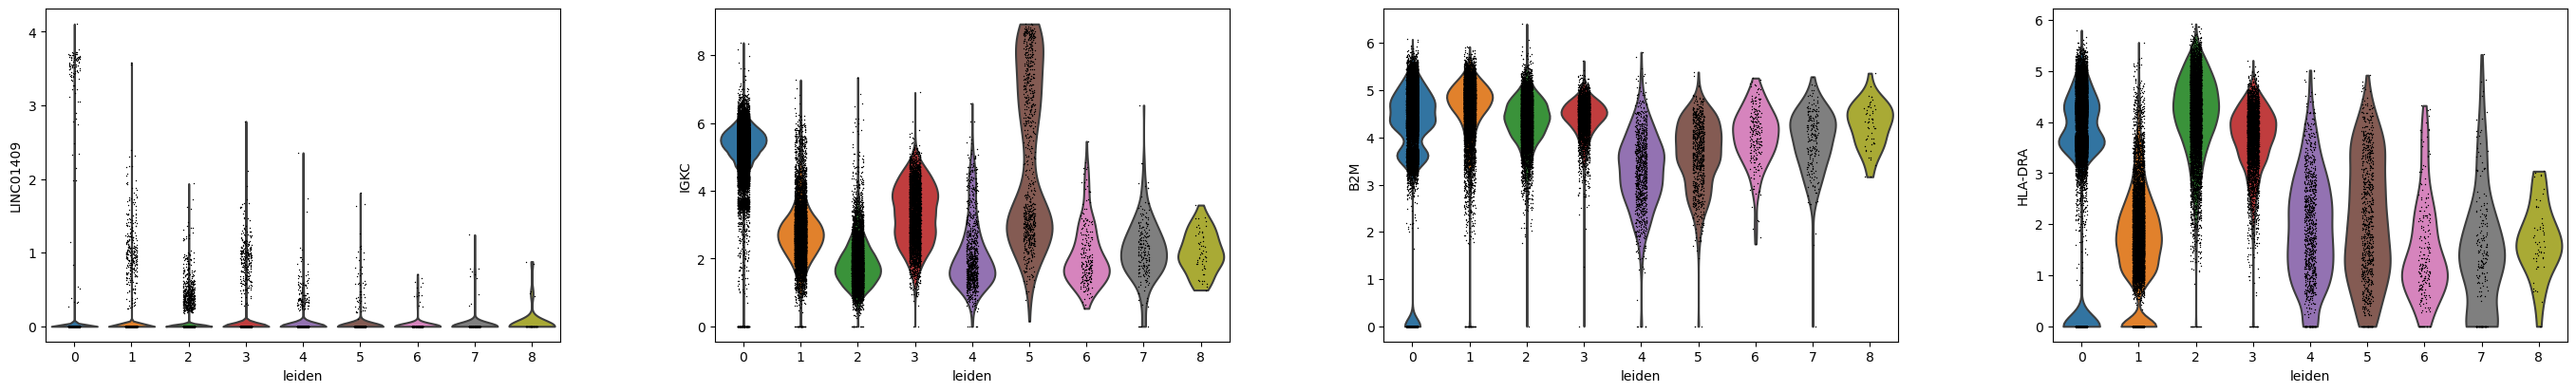

In [43]:
sc.pl.violin(adata, ['LINC01409', 'IGKC', 'B2M', 'HLA-DRA'], groupby='leiden', use_raw = True)